# Module 02_04: SVC: targeting CPU and Patching 

![Assets/SVCacceleration.jpg](Assets/SVCacceleration.jpg)


# Learning Objectives:

1) Describe how to surgically unpatch specific optimized functions if needed
2) Describe differences in patching more globally versus more surgically
1) applied patching to SVC algorithm
2) Describe acceleration for the covtype dataset usinf SVC



# *Real World* example SVC on CovType Dataset

### Compare timings of stock kmeans versus Intel Extension for Scikit-learn SVC using patch_sklean()

Below we will apply Intel Extension for Scikit learn to a use case on a CPU

Intel® Extension for Scikit-learn contains drop-in replacement functionality for the stock scikit-learn package. You can take advantage of the performance optimizations of Intel Extension for Scikit-learn by adding just two lines of code before the usual scikit-learn imports. Intel® Extension for Scikit-learn patching affects performance of specific Scikit-learn functionality.

### Data: covtype

We will use forest cover type dataset known as covtype and fetch the data from sklearn.datasets


Here we are **predicting forest cover type** from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.


Predicting forest cover type from cartographic variables only (no remotely sensed data). The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. Independent variables were derived from data originally obtained from US Geological Survey (USGS) and USFS data. Data is in raw form (not scaled) and contains binary (0 or 1) columns of data for qualitative independent variables (wilderness areas and soil types).

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

### Overview of procedure
In the below example we will train and predict kNN algorithm with Intel Extension for Scikit-learn for covtype dataset and calculate the CPU and wall clock time for training and prediction. Then in the next step we will unpatch the Intel extension for Scikit-learn and observe the time taken on the CPU for the same trainng and prediction.

### Fetch the Data

- [Back to Sections](#Back_to_Sections)


In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import time
import numpy as np
import numpy.ma as ma

connect4 = pd.read_csv('data/connect-4.data')

data = connect4.iloc[:,:42].replace(['x', 'o', 'b'], [0,1,2])

keep = .25 # amount of data to experiment with to keep times reasonable
subsetLen = int(keep*data.shape[0])

X = np.byte( data.iloc[:subsetLen,:].to_numpy() )
X = X[:subsetLen,:42]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
enc.categories_

XOHE = np.short(enc.transform(X).toarray() )# X one hot encoded

Data_y = connect4.iloc[:,42].to_numpy()
#np.random.shuffle(Data_y)
y =  Data_y[:subsetLen] 

from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn('train_test_split')  #surgically patch train_test_split
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(XOHE, y, train_size=0.80, test_size=0.20, random_state=101)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.metrics import classification_report

def predict( linear ):
    import numpy as np
    time_patch_predict = time.time()
    y_pred = linear.predict(X_test)
    elapsed = time.time() - time_patch_predict
    return elapsed, y_pred

def fit():
    start = time.time()
    linear = svm.SVC(kernel='linear', C=100).fit(X_train, y_train)
    time_patch_fit =  time.time() - start
    return time_patch_fit, linear


In [3]:
from sklearn.metrics import classification_report

# Apply the unpatch_sklearn() function to this cell then run the cell and note the time:

###############################
## add patch here ##
from sklearnex import patch_sklearn, unpatch_sklearn
unpatch_sklearn()

###############################
from sklearn import svm
unpatch_time_fit, linear = fit()
unpatch_time_predict, y_pred = predict(linear)
target_names = ['win', 'loss', 'draw']
print("file as is ")
print(classification_report(y_test, y_pred, target_names=target_names))
print('Elapsed time: {:.2f} sec'.format( unpatch_time_fit + unpatch_time_predict))

file as is 
              precision    recall  f1-score   support

         win       0.45      0.02      0.04       231
        loss       0.68      0.59      0.63       614
        draw       0.85      0.95      0.89      2533

    accuracy                           0.82      3378
   macro avg       0.66      0.52      0.52      3378
weighted avg       0.79      0.82      0.79      3378

Elapsed time: 96.17 sec


In [4]:
from sklearn.metrics import classification_report

# Apply the patch_sklearn() function to this cell then run the cell and note the time:

###############################
## add patch here ##
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()

###############################
from sklearn import svm
patch_time_fit, linear = fit()
patch_time_predict, y_pred = predict(linear)
target_names = ['win', 'loss', 'draw']
print("file as is ")
print(classification_report(y_test, y_pred, target_names=target_names))
print('Elapsed time: {:.2f} sec'.format( patch_time_fit + patch_time_predict))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


file as is 
              precision    recall  f1-score   support

         win       0.45      0.02      0.04       231
        loss       0.68      0.59      0.63       614
        draw       0.85      0.95      0.89      2533

    accuracy                           0.82      3378
   macro avg       0.66      0.52      0.52      3378
weighted avg       0.79      0.82      0.79      3378

Elapsed time: 12.33 sec


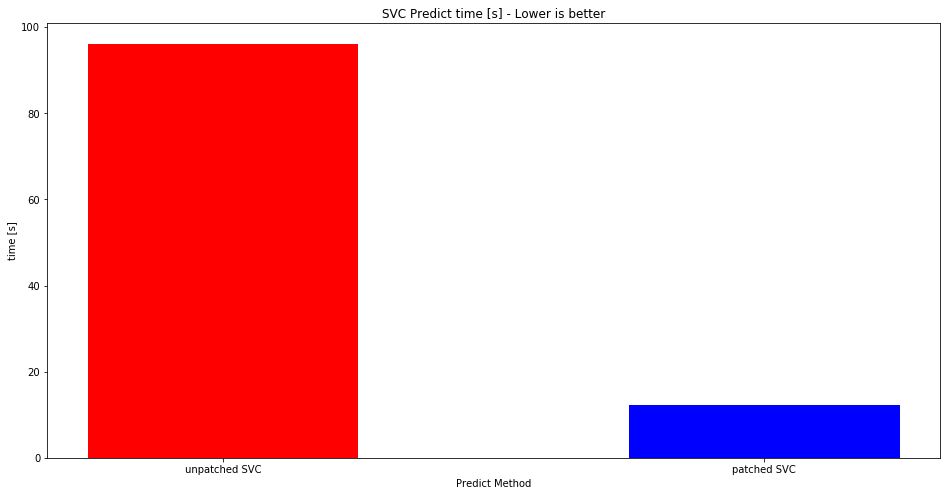

Intel(R) Extensions for scikit-learn*  SVC Speedup  7.8 x!


In [5]:
# Copyright 2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
%matplotlib inline
import matplotlib.pyplot as plt

left = [1,2]
pred_times = [unpatch_time_fit + unpatch_time_predict, patch_time_fit + patch_time_predict]
tick_label = ['unpatched SVC', 'patched SVC']
plt.figure(figsize = (16,8))
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Predict Method'); plt.ylabel('time [s]'); plt.title('SVC Predict time [s] - Lower is better')
plt.show()

print('Intel(R) Extensions for scikit-learn* \033[1m SVC Speedup {:4.1f} x!\033[0m'.format( (unpatch_time_fit + unpatch_time_predict)/(patch_time_fit + patch_time_predict)))

Compare the times and accuracies of these two runs. 

Is the time versus accuracy trade off worth the effort to patch this function?

Reminder of how to find the list of functions available to patch


# Summary:

You have:

1) applied patching to SVC algorithm
2) Describe acceleration for tehe covtype dataset
    

# Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation.
No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.